<center><span style="font-size:25px;">КЛАССИФИКАЦИЯ ПИСЕМ НА СПАМ - НЕ СПАМ</span></center>

Описания особого нет.  

В датасете 2 столбца:
- метки классов
- сами письма

Проект был сделан на `Python 3.11.6`

<h2 id='contents'>Оглавляшка:</h2>

* [Загружаемые библиотеки](#libs)
* [Загрузка данных и баланс таргета](#dataload)
* [Удаление пропусков, пустых строк и векторизация текста](#nandelvector)
* [Разделение выборки на train и test](#trtsplit)
* [Обучение НБ классификаторов](#naibaytraining) `ComplementNB` и `MultinomialNB`
* [ComplementNB через GridSearchCV](#cmbviags)

## Загружаемые библиотеки <a id='libs'></a>

In [1]:
from data.functions_akialema import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
plt.rcParams['font.family'] = 'DejaVu Sans'
%matplotlib inline

## Загрузка данных и определение баланса таргета <a id='dataload'></a>

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=16m79AklN-Lq0psLCi69I1A8caNOFVNBa')

my_info(df)

memory usage: 4.4 MB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,label,2,int64,0,3000,0,127,min...: 0.00max..: 1.00mean: 0.17std....: 0.37
1,email,2872,object,url URL date not supplied URL,3000,1,127,see type column


Наблюдается 1 пропущеное значение и 127 дублей.

Взглянем на баланс:

Баланс сил:
0    2500
1     500
Name: count, dtype: int64

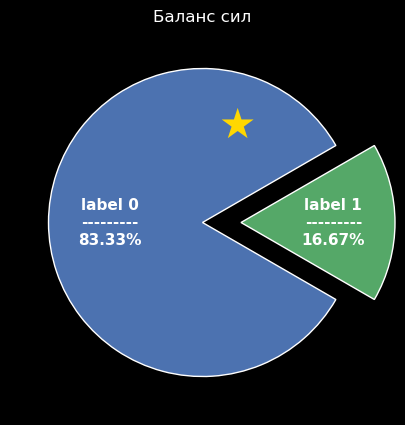

In [3]:
df_for_this_cell = (df['label'].value_counts(normalize=True) * 100).to_frame()
df_for_this_cell.index = ['label 0', 'label 1']
display(df['label'].rename('Баланс сил:').value_counts())

fig, ax = plt.subplots(figsize=(10, 5))
ax.pie(df_for_this_cell['proportion'],
       autopct=absolute_value_generator(df_for_this_cell, targcol='proportion', val_las_symbol='%'),
       explode=[0, 0.25],
       textprops={'color': 'white', 'weight': 'bold', 'fontsize': 11}, startangle=30,
       wedgeprops={'edgecolor': 'white', 'linewidth': 1})

fig.set_facecolor('#000000')
ax.text(0.1, 0.55, '★', color='gold', fontsize=30)
ax.set_title('Баланс сил', color='white')
plt.show()

## Удаление пропусков, пустых строк и векторизация текста <a id='nandelvector'></a>

[↑ contents](#contents)

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [4]:
# подход не универсальный, но для данного датасета вполне подходит.
indexers_to_drop = df[df['email'].astype(str).str.split(' ').apply(lambda x: list(set(x))).apply(lambda x: len(x)) < 2].index
display(df.iloc[indexers_to_drop])

df = df.drop(index=indexers_to_drop).reset_index(drop=True)
df.shape

,email,label
2806,,1
2828,,1
2966,NaN,1


(2997, 2)

Переводим данные в векторный вид:

In [5]:
vectorizer = CountVectorizer()
vec_matrix = vectorizer.fit_transform(df["email"])

pd.DataFrame(vec_matrix.toarray(), columns=vectorizer.get_feature_names_out()).head()

,__,___,____,_____,______,_______,________,_________,__________,______________,...,허락없이,헤어디자이너,현재,호황을,홈쇼핑의,확실한,활황을,훨씬,힘입어,ｉt的技
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Определите, сколько теперь признаков в нашем наборе данных:

In [6]:
# Тут, кстати, не совсем понятно. "Наш" набор данных - это df, в котором 2 признака. 
# А "векторизер" создаёт отдельную матрицу, которая, по сути, является дополнительной, которую можно приклеить к "нашему".
# Но т.к. там всего 2 столбца, один из которых - целевой, а второй мы векторизируем, то это бессмысленно.
print('"Векторизатор" создал %.0f признаков.' % (vec_matrix.shape[1]))

"Векторизатор" создал 34116 признаков.


## Разделение выборки на train и test <a id='trtsplit'></a>

[↑ contents](#contents)

Определите целевую переменную и признаки:

In [7]:
X = vec_matrix
y = df['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

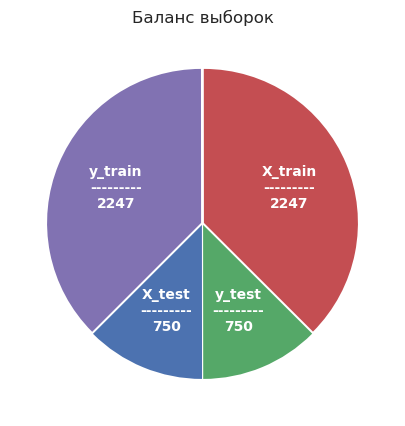

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

df_for_this_cell = pd.DataFrame([list(X_train.shape), list(X_test.shape), list(y_train.shape), list(y_test.shape )],
                                index=['X_train', 'X_test', 'y_train', 'y_test'],
                                columns=['num_of_rows', 'num_of_cols'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.pie(df_for_this_cell['num_of_rows'].sort_values(),
       autopct=absolute_value_generator(df=df_for_this_cell, targcol='num_of_rows', sort=True, val_type='int'),
       explode=[0.01, 0.01, 0.01, 0.01],
       textprops={'color': 'white', 'weight': 'bold', 'fontsize': 10}, startangle=225)
ax.set_title('Баланс выборок')
plt.show()

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [9]:
print('Среднее значение целевой переменной по тестовой выборке = %.3f' % (y_test.mean()))

Среднее значение целевой переменной по тестовой выборке = 0.165


## Обучение НБ классификаторов <a id='naibaytraining'></a>

[↑ contents](#contents)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [10]:
cnb = ComplementNB(alpha=0.01).fit(X_train, y_train)
mnb = MultinomialNB(alpha=0.01).fit(X_train, y_train)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [11]:
print_metrics(y_test=y_test,
              y_test_pred=[cnb.predict(X_test), mnb.predict(X_test)],
              list_of_metrics=['accuracy_score', 'precision_score', 'recall_score', 'f1_score'],
              names=['ComplementNB_model', 'MultinomialNB_model']).round(3)

,ComplementNB_model,MultinomialNB_model
accuracy,0.988,0.987
precision,1.000,1.000
recall,0.927,0.919
f1,0.962,0.958


Нарисуйте ROC-кривую:

ComplementNB: ROC AUC = 0.995066


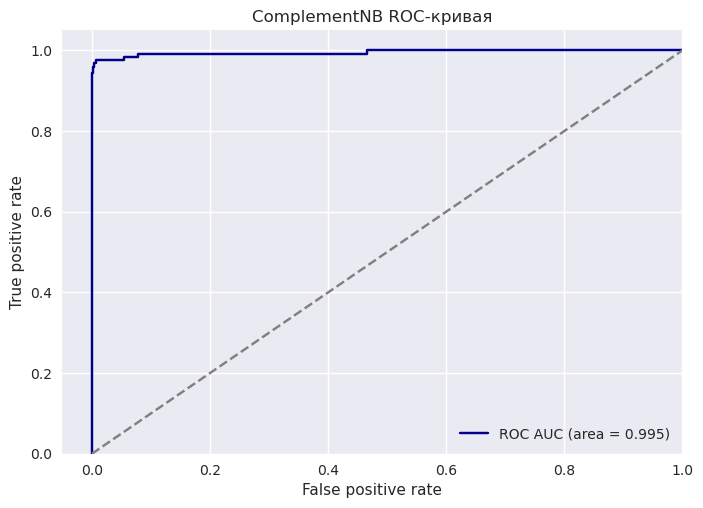

In [12]:
custom_roc_curve(X_test=X_test, y_test=y_test, model=cnb, model_name='ComplementNB').show()

## ComplementNB через GridSearchCV <a id='cmbviags'></a>

[↑ contents](#contents)

Переберите несколько значений `alpha` с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [13]:
# Я на самом деле не знаю, куда улучшать, но давайте попробуем.
# Так же я не совсем понимаю, как перебирать гиперпараметр с помощью только кросс-валидации. 
# Потому буду использовать.. пусть будет GridSearch.
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.arange(0.02, 0.41, 0.01)}

grid_search = GridSearchCV(estimator=ComplementNB(),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f'Лучшие параметры: {grid_search.best_params_}')

print_metrics(y_train=y_train, y_test=y_test,
              y_train_pred=[grid_search.predict(X_train), cnb.predict(X_train)],
              y_test_pred=[grid_search.predict(X_test), cnb.predict(X_test)],
              list_of_metrics=['accuracy_score', 'precision_score', 'recall_score', 'f1_score'], 
              names=['Adjusted_ComplementNB', 'ComplementNB']).T.sort_index(level=1, ascending=False).round(3)

Лучшие параметры: {'alpha': 0.23999999999999996}


,,accuracy,precision,recall,f1
train,ComplementNB,1.000,1.000,0.997,0.999
test,ComplementNB,0.988,1.000,0.927,0.962
train,Adjusted_ComplementNB,0.999,1.000,0.995,0.997
test,Adjusted_ComplementNB,0.995,0.992,0.976,0.984


Как оказалось, есть куда улучшать.) Метрики выровнялись. Ответ: для данного датасета - да, зависит.

[↑ contents](#contents)